# MaveDB Mapping Method Analysis
This notebook assesses the performance of the mapping method, comparing the match between reference sequences for pre-mapped and post-mapped VRS objects. This notebook also computes the number of unique VRS alleles generated across the examined score sets and creates associated figures.

## Load Relevant Libraries
Run the cell below to load the libraries used in the analysis

In [1]:
import json

import pandas as pd
from cool_seq_tool.schemas import Strand

## Load List of Examined Score Sets

Run the cells below to a load a list of processed score sets and their corresponding alignment data

In [2]:
mave_metadata_dat = pd.read_csv("analysis_files/mave_metadata_20241114.csv", index_col=[0])
score_sets = mave_metadata_dat["urn"].to_list()

In [3]:
import pickle
from pathlib import Path

with Path.open("analysis_files/score_sets_strands.pkl", "rb") as fn:
    strand_dict = pickle.load(fn)

## Determine the MaveDB IDs of Variants with Reference Mismatches
Run the cells below to generate a dictionary listing the MaveDB IDs of variants with reference mismatches. The dictionary is keyed by score set URN.

In [4]:
def get_post_mapped_variant(pre_mapped_digest: str, post_mapped_variants: dict) -> dict | None:
    """Given a pre-mapped digest, find the corresponding post-mapped variant

    :param pre_mapped_digest: The pre-mapped variant digest
    :param post_mapped_variants: A dictionary representing the post-mapped variants attribute
    :return The post-mapped variant that contains the queried pre-mapped digest, or None if it does not exist
    """
    # Check if post_mapped_variants is a single variant or list
    if "members" not in post_mapped_variants:
        return post_mapped_variants if post_mapped_variants["extensions"][1]["value"] == pre_mapped_digest else None
    variant_to_return = None
    for variant in post_mapped_variants["members"]:
        for extension in variant["extensions"]:
            if extension["name"] == "pre_mapped_id" and extension["value"] == pre_mapped_digest:
                variant_to_return = variant
                break
    return variant_to_return

In [5]:
def is_concordant(pre_mapped: str, post_mapped: str, rc: str, seq_type: str, strand: Strand,) -> bool:
    """Determine whether or not a variant mapping displays concordance

    :param pre_mapped: The pre-mapped reference sequence
    :param post_mapped: The post-mapped reference sequence
    :param rc: The reverse complement sequence
    :param seq_type: The sequence type
    :param strand: Strand
    :return ``True`` if the pre_mapped and post_mapped sequence are equivalent, ``False`` if not
    """
    if seq_type == "protein" and pre_mapped == post_mapped:
        return True
    if seq_type == "dna":
        if strand == Strand.POSITIVE and pre_mapped == post_mapped:
            return True
        if strand == Strand.NEGATIVE and post_mapped == rc:
            return True
    return False

In [6]:
import os

from Bio.Seq import Seq

var_count = 0
diff_vars_dict = {}

for urn in score_sets:
    files = list(Path("analysis_files/mappings").glob(f"*{urn}_mapping*"))
    if files:
        latest_file = max(files, key=os.path.getmtime)
    else:
        continue

    f = Path.open(latest_file)
    dat = json.load(f)
    computed_seq_type = dat["computed_reference_sequence"]["sequence_type"]
    dat = dat["mapped_scores"]

    diff_vars = []
    strand = strand_dict[urn]

    for j,var_mapping in enumerate(dat):
        # Check if post-mapped variant exists
        if "post_mapped" in var_mapping:

            if "members" not in var_mapping["pre_mapped"]:
                var_count += 1
                seq_pre = var_mapping["pre_mapped"]["location"]["sequence"]
                seq_post = var_mapping["post_mapped"]["location"]["sequence"]
                seq_pre_rv = str(Seq(seq_pre).reverse_complement())

                if not is_concordant(seq_pre, seq_post, seq_pre_rv, computed_seq_type, strand,):
                    diff_vars.append(j)

            else:
                for pre_mapped_var in var_mapping["pre_mapped"]["members"]:
                    post_mapped_var = get_post_mapped_variant(pre_mapped_var["id"], var_mapping["post_mapped"])
                    if post_mapped_var:
                        var_count += 1
                        seq_pre = pre_mapped_var["location"]["sequence"]
                        seq_post = post_mapped_var["location"]["sequence"]
                        seq_pre_rv = str(Seq(seq_pre).reverse_complement())

                        if not is_concordant(seq_pre, seq_post, seq_pre_rv, computed_seq_type, strand,):
                            diff_vars.append(j)
    diff_vars_dict[urn] = diff_vars

f"The number of examined variant pairs is: {var_count}"

'The number of examined variant pairs is: 8998024'

### The cell below can be uncommented to examine the output of the above cell

In [7]:
#diff_vars_dict

### Examine Example Mismatch
Run the cell below to view an example of reference mismatch discordance due to a MAVE variant that spans an alignment block

In [8]:
f = Path.open("analysis_files/mappings/urn:mavedb:00000005-a-6_mapping_2025-02-19T15:09:56.042819+00:00.json")
dat = json.load(f)
dat["mapped_scores"][5600]

{'pre_mapped': {'id': 'ga4gh:VA.NGzY57_jBg6zCP4LfaCq6gpidyInuNsR',
  'type': 'Allele',
  'extensions': [{'name': 'vrs_v1.3_id',
    'value': 'ga4gh:VA.cOIjqyFdmw-1KgSvv2fIagTfoK2qvhcD'}],
  'location': {'type': 'SequenceLocation',
   'digest': 'NJvfZvx6abQhGlcyo8aJnWPxEnHOvi7y',
   'sequenceReference': {'type': 'SequenceReference',
    'refgetAccession': 'SQ.sVMC1jmTXRvuzBCDJ8aoBmZ_Uu35YFj7'},
   'start': 316,
   'end': 318,
   'sequence': 'TG'},
  'state': {'type': 'LiteralSequenceExpression', 'sequence': 'CT'}},
 'post_mapped': {'id': 'ga4gh:VA.vM4JPTj7doGBiNJbeNFbCadNNefs7Qip',
  'type': 'Allele',
  'extensions': [{'name': 'vrs_v1.3_id',
    'value': 'ga4gh:VA.x6o-gvLsQVSB7BdxrFiA1V8CcK4MKaZr'},
   {'name': 'pre_mapped_id',
    'value': 'ga4gh:VA.NGzY57_jBg6zCP4LfaCq6gpidyInuNsR'}],
  'expressions': [{'syntax': 'hgvs.g', 'value': 'NC_000021.9:g.43068508C>G'}],
  'location': {'type': 'SequenceLocation',
   'digest': 'QOxE1Q4pkFTeUZtsq58c_he9jY-V0I3k',
   'sequenceReference': {'type':

## Compute the Proportion of Reference Mismatches

The cell below computes the proportion of reference mismatches among all MAVE variants that have been mapped.

In [9]:
mm_count = 0
for key in diff_vars_dict:
    mm_count = mm_count + len(diff_vars_dict[key])
f"There are {mm_count} instances of reference mismatch. This corresponds to a percentage of {round(100*mm_count/var_count,3)} ({mm_count}/{var_count})"

'There are 2839573 instances of reference mismatch. This corresponds to a percentage of 31.558 (2839573/8998024)'

Caveat: This percentage could be influenced due to factors including:
1. Point mutations in target sequences that cause discordance with the human reference sequence, even though the mapped position is correct
2. The normalization of MAVE variants that span intron-exon boundaries can lead to concordant variant pairs, even though the positions for parts of the indel event may overlap with intronic space
3. Some score sets may include variants that occur past the target sequence length, leading to discordance with the mapped variants

Run the cell below to determine the number of discordant pairs from score sets generated in the "Mega-scale experimental analysis of protein folding stability in biology and design" paper

In [10]:
filtered_list = score_sets[243:504]
mm_count = 0

for key in filtered_list:
    mm_count = mm_count + len(diff_vars_dict[key])
f"There are {mm_count} instances of reference mismatch in the subset"

'There are 2806609 instances of reference mismatch in the subset'

## Generate VRS Allele ID Dictionary
Run the cell below to generate a VRS allele ID dictionary for the concordant MAVE variants. The dictionary is keyed by the post-mapped VRS allele IDs, and each key's contents contain a list of corresponding pre-mapped VRS allele IDs.

In [11]:
allele_list_dict = {}
for urn in score_sets:
    files = list(Path("analysis_files/mappings").glob(f"*{urn}_mapping*"))
    if files:
        latest_file = max(files, key=os.path.getmtime)
    else:
        continue

    f = Path.open(latest_file)
    dat = json.load(f)
    computed_seq_type = dat["computed_reference_sequence"]["sequence_type"]
    dat = dat["mapped_scores"]

    diff_vars = []
    strand = strand_dict[urn]

    for _,var_mapping in enumerate(dat):
        # Check if post-mapped variant exists
        if "post_mapped" in var_mapping:
            if "members" not in var_mapping["pre_mapped"]:
                # Test if pre_mapped and post_mapped variants are concordant
                concordant = is_concordant(var_mapping["pre_mapped"]["location"]["sequence"],
                                                var_mapping["post_mapped"]["location"]["sequence"],
                                                str(Seq(var_mapping["pre_mapped"]["location"]["sequence"]).reverse_complement()),
                                                computed_seq_type,
                                                strand)
                if concordant:
                    va = var_mapping["post_mapped"]["id"]
                    if va not in allele_list_dict:
                        allele_list_dict[va] = [var_mapping["pre_mapped"]["id"]]
                    else:
                        if var_mapping["pre_mapped"]["id"] not in allele_list_dict[va]:
                            tmp = allele_list_dict[va]
                            tmp.append(var_mapping["pre_mapped"]["id"])
                            allele_list_dict[va] = tmp
            else:
                for pre_mapped_var in var_mapping["pre_mapped"]["members"]:
                    post_mapped_var = get_post_mapped_variant(pre_mapped_var["id"], var_mapping["post_mapped"])
                    if post_mapped_var:
                        # Test if pre-mapped and post-mapped variants are concordant
                        concordant = is_concordant(pre_mapped_var["location"]["sequence"],
                                                post_mapped_var["location"]["sequence"],
                                                str(Seq(pre_mapped_var["location"]["sequence"]).reverse_complement()),
                                                computed_seq_type,
                                                strand)
                        if concordant:
                            va = post_mapped_var["id"]
                            if va not in allele_list_dict:
                                allele_list_dict[va] = [pre_mapped_var["id"]]
                            else:
                                if pre_mapped_var["id"] not in allele_list_dict[va]:
                                    tmp = allele_list_dict[va]
                                    tmp.append(pre_mapped_var["id"])
                                    allele_list_dict[va] = tmp

### Analyze VRS Allele ID Dictionary
Run the cell below to derive relevant statistics from the VRS allele ID dictionary

In [12]:
print(f"There are {len(allele_list_dict)} unique post-mapped MAVE variants in the allele dictionary")

pre_mapped_variants = 0
for key in allele_list_dict:
    pre_mapped_variants += len(allele_list_dict[key])
print(f"The {len(allele_list_dict)} post-mapped variants are associated with {pre_mapped_variants} pre-mapped variants")

print(f"There are {len({var for var_list in allele_list_dict.values() for var in var_list})} unique pre-mapped MAVE variants in the allele dictionary")

There are 1018091 unique post-mapped MAVE variants in the allele dictionary
The 1018091 post-mapped variants are associated with 1050108 pre-mapped variants
There are 1048823 unique pre-mapped MAVE variants in the allele dictionary


## Compute the Number of Processed Variants Across the Examined Score Sets
Run the cell below to compute the number of variants that were processed across the 209 examined score sets

In [13]:
var_count = 0
for urn in score_sets:
    files = list(Path("analysis_files/mappings").glob(f"*{urn}_mapping*"))
    if files:
        latest_file = max(files, key=os.path.getmtime)
    else:
        continue

    f = Path.open(latest_file)
    dat = json.load(f)
    computed_seq_type = dat["computed_reference_sequence"]["sequence_type"]
    dat = dat["mapped_scores"]
    var_count += len(dat)
f"There are {var_count} MAVE variants that were processed in this analysis"

'There are 2994178 MAVE variants that were processed in this analysis'

## Compute Score Set Summary Statistics
Run the cell below to compute relevant mapping summary statistics

In [14]:
import numpy as np

variant_count_dict = {}
for urn in score_sets:
    files = list(Path("analysis_files/mappings").glob(f"*{urn}_mapping*"))
    if files:
        latest_file = max(files, key=os.path.getmtime)
    else:
        continue

    f = Path.open(latest_file)
    dat = json.load(f)
    computed_seq_type = dat["computed_reference_sequence"]["sequence_type"]
    dat = dat["mapped_scores"]
    variant_count_dict[urn] = len(dat)

min_value = min(variant_count_dict.values())
min_value_dict = [key for key, value in variant_count_dict.items() if value == min_value]
print(f"The score set(s) with the fewest number of processed variants is {min_value_dict} with {min_value} variants")

max_value = max(variant_count_dict.values())
max_value_dict = [key for key, value in variant_count_dict.items() if value == max_value]
print(f"The score set(s) with the largest number of processed variants is {max_value_dict} with {max_value} variants")

mean_value = sum(variant_count_dict.values()) / len(variant_count_dict)
print(f"The average number of processed variants per score was {mean_value}")

median_variants = np.median(list(variant_count_dict.values()))
print(f"The median number of variants per score set is {median_variants}")

values = list(variant_count_dict.values())
iq25, iq75 = np.percentile(values, [25,75])
print(f"The interquartile range falls between {iq25} and {iq75}")

The score set(s) with the fewest number of processed variants is ['urn:mavedb:00000094-a-1'] with 1 variants
The score set(s) with the largest number of processed variants is ['urn:mavedb:00000053-a-1'] with 648022 variants
The average number of processed variants per score was 2832.713339640492
The median number of variants per score set is 1289.0
The interquartile range falls between 920.0 and 1794.0


In [15]:
stats_data = {
    "Number of Examined Variant Pairs": "8998024 (100%)",
    "Number of Concordant Variant Pairs": "6158451 (68.44%)",
    "Number of Pairs of Reference Mismatch": "2839573 (31.56%)",
    "Number of Unique Pre-Mapped Variants": 1048823,
    "Number of Unique Post-Mapped Variants": 1018091,
    "Minimum Number of Variants in a Score Set": 1,
    "Maximum Number of Variants in a Score Set": 648022,
    "Average Number of Variants in a Score Set": 2833,
    "Median Number of Variants in a Score Set": 1289,
    "Interquartile Range for Variants in a Score Set (25-75%)": "(920, 1794)"
}
stats_data = pd.DataFrame.from_dict(stats_data, orient="index", columns=["Value"])
stats_data

,Value
Number of Examined Variant Pairs,8998024 (100%)
Number of Concordant Variant Pairs,6158451 (68.44%)
Number of Pairs of Reference Mismatch,2839573 (31.56%)
Number of Unique Pre-Mapped Variants,1048823
Number of Unique Post-Mapped Variants,1018091
Minimum Number of Variants in a Score Set,1
Maximum Number of Variants in a Score Set,648022
Average Number of Variants in a Score Set,2833
Median Number of Variants in a Score Set,1289
Interquartile Range for Variants in a Score Set (25-75%),"(920, 1794)"


## Create Histogram to Visualize Variant Counts Across Score Sets
Run the cell below to create a historgram visualizing variant counts across the processed score sets

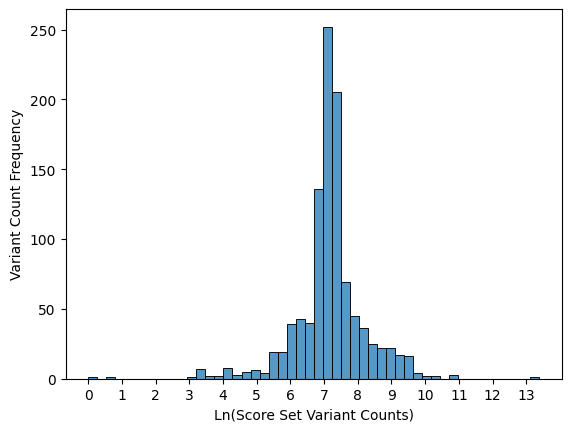

In [16]:
import math

import matplotlib.pyplot as plt
import seaborn as sns

variant_counts = list(variant_count_dict.values())
log_variant_counts = [math.log(count) for count in variant_counts]

ax = sns.histplot(log_variant_counts, bins=50, edgecolor="black")
plt.xticks(np.arange(0, 14, step=1))
plt.yticks(np.arange(0, 300, step=50))
plt.xlabel("Ln(Score Set Variant Counts)")
plt.ylabel("Variant Count Frequency")

plt.savefig("variant_counts.png", dpi=300)
plt.show()

## Visualize VRS ID Equivalence in Variant Mappings
Run the cells below to create a pie chart visualizing the equivalence in variant mapping pairs

In [17]:
def compare_alleles(key: str, allele_list: list[str]) -> bool:
    """Iterate through a list of pre-mapped variants, and determine if it matches the post-mapped variant

    :param key: The post-mapped variant VRS ID
    :param allele_list: The list of pre-mapped variant VRS IDs
    :return ``True`` if one pre-mapped VRS ID is equivalent to the key, ``False`` if not
    """
    return any(vrs_id == key for vrs_id in allele_list)

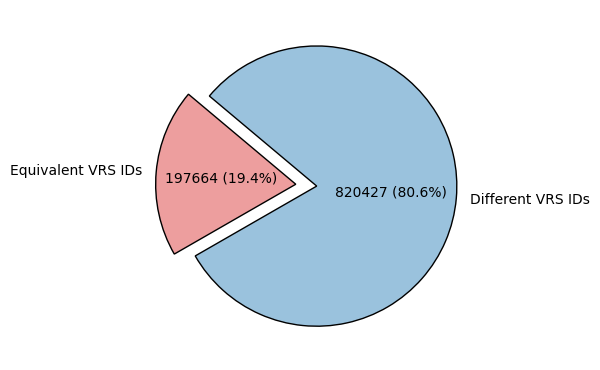

In [18]:
# Create pie chart showing how often the components in a mapping pair have different VRS IDs, highlighting need for mapping procedure
same_ids = 0
for key in allele_list_dict:
    if compare_alleles(key, allele_list_dict[key]):
        same_ids += 1
diff_ids = len(allele_list_dict) - same_ids
params = {"Same VRS IDs": [True, False],
          "Value": [same_ids, diff_ids]}
compare_alleles_df = pd.DataFrame(params)

labels = "Equivalent VRS IDs", "Different VRS IDs"
colors = ["#ED9E9E", "#9AC2DD"]

fig, ax = plt.subplots(figsize=(6, 6))
sizes = compare_alleles_df["Value"].to_list()

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: f"{round(pct/100.*sum(sizes))} ({pct:.1f}%)",
    colors=colors,
    startangle=140,
    explode=(0.05, 0.1),
    shadow=False,
    wedgeprops={"edgecolor": "black"}
)

for text in texts + autotexts:
    text.set_fontsize(10)

for _, autotext in enumerate(autotexts):
    autotext.set_fontsize(10)
    autotext.set_position((0.9 * autotext.get_position()[0], 0.8 * autotext.get_position()[1]))

plt.tight_layout()

# Save plot
plt.savefig("mapped_variants_count.png", dpi=300)
plt.show()